# Decision Tree

The reason for makeing this notebook was to see how to run a classic decision tree algorithm plus, decision tree with bagging and a random forest. I will not strive to implement such an algorithm from scratch, but I will use scikit learn library. I will work with the mtcars data set.

Here are the objectives for the notebook:

* Import mtcars data form local csv file, clean and build features - standarize and perform one-hot encoding where necessary
* Run a classic decision tree classifier to that classifies high fuel consumption 
* Play around with the algorithm - check if we could get similar accuracy with less features, with less tree depth and so forth. 
* Add a bagging ensemble fot the classic decision tree clasifier.
* Grow a random forrest of decision trees and see if that improves in any way the accuracy


### Get mtcars data and build features

In [203]:
import numpy as np
import pandas as pd
import csv
import itertools
from sklearn import tree
# Look at some ensemble methods:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier 

from matplotlib import pyplot as plt
import random

def load_data(path):
    '''
    takes path and returns a pnadas data frame object with the data from file under path
    '''
    data = []
    with open(path) as f:
        for row in csv.DictReader(f, delimiter='\t'):
            data.append(row)
    return pd.DataFrame(data)


def one_hot(x):
    '''
    @param x : pandas series object
    returns a data frame with the original series and the one hot encoded fields
    '''
    
    new_frame = pd.DataFrame(x)
    for val in x.unique():
        _name = str(int(val))
        new_frame[x.name + _name] = new_frame.apply(lambda col: 1 if col[x.name] == val else 0, axis=1)
    return new_frame.iloc[:,1:]
        
    
def standardize(x):
    '''
    @param x : string holding the name of the field to be standarized
    '''
    z = x.astype('float')
    result = np.array((z - np.mean(z))/np.std(z))

    return pd.DataFrame(result, columns=[x.name])


def make_features(feature_list):
    '''
    @param feature_list: a list of tuples, first entry is a pandas series and the next one is a string with 
    onehot or standardize. 
    '''
    new_features = []
    for f,ftype in feature_list:
        if ftype == 'onehot':
            new_features.append(one_hot(f))
        elif ftype == 'standardize':
            new_features.append(standardize(f))
        else:
            new_features.append(f)
        
    return pd.concat(new_features, axis=1)



auto_data = load_data('auto-mpg.tsv')


features = [
            (auto_data.cylinders, 'onehot'),
            (auto_data.displacement, 'standardize'),
            (auto_data.horsepower, 'standardize'),
            (auto_data.weight, 'standardize'),
            (auto_data.acceleration, 'standardize'),
            (auto_data.origin, 'onehot'),
            (auto_data.mpg, 'standardize')
            ]


auto_data = make_features(features)


# Split into train and test. I will not use a validation set in this endeavor
rng = np.random.default_rng(seed=0)

rand_ind = (rng.random(auto_data.shape[0])<0.75)
X_train, X_test  = auto_data[rand_ind].iloc[:,:-1], auto_data[~rand_ind].iloc[:,:-1]
Y_train, Y_test =  auto_data[rand_ind].iloc[:,-1], auto_data[~rand_ind].iloc[:,-1]


### Build a classic decision tree classifier

In [191]:

DTC = tree.DecisionTreeClassifier(
        criterion='gini', # gini purity measusre
        splitter='best',
        min_samples_split=2, # will not split reagions that have less than 4 sample points 
        min_samples_leaf=1,  # minimal leaf size
        random_state = 0, # if more than one split generates the same gini index, than a spit will be chosen at random. 
                        # Adding this 'seed' should secure determininistic behavior
        max_features = None,# Use all features at each split.
        ccp_alpha = 0.0 # This is a regularization feature, i.e the tree will be pruned to so that 
                # it doesn't containg too many leaves and hence doesn't oerfit
)

classifier = DTC.fit(X_train, Y_train)

Plot the tree and see which features are at the top

[Text(0.553030303030303, 0.9375, 'x[3] <= 0.5\ngini = 0.5\nsamples = 277\nvalue = [136, 141]'),
 Text(0.2727272727272727, 0.8125, 'x[5] <= -0.629\ngini = 0.175\nsamples = 134\nvalue = [121, 13]'),
 Text(0.12121212121212122, 0.6875, 'x[8] <= -0.904\ngini = 0.498\nsamples = 15\nvalue = [7, 8]'),
 Text(0.09090909090909091, 0.5625, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.15151515151515152, 0.5625, 'x[8] <= 0.076\ngini = 0.486\nsamples = 12\nvalue = [7, 5]'),
 Text(0.09090909090909091, 0.4375, 'x[5] <= -0.786\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.06060606060606061, 0.3125, 'x[7] <= -0.124\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.030303030303030304, 0.1875, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.09090909090909091, 0.1875, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.12121212121212122, 0.3125, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.21212121212121213, 0.4375, 'x[7] <= 0.604\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Tex

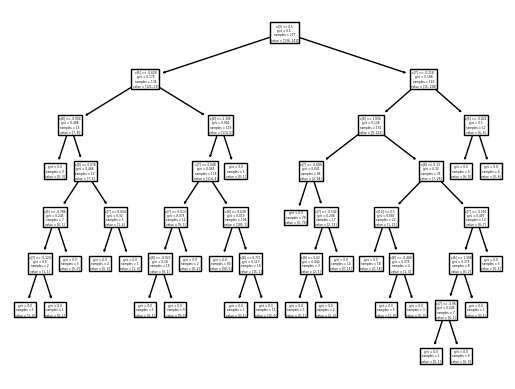

In [192]:
tree.plot_tree(classifier)

### Play around with the model

I now test how accurate is the decision tree model using 1-fold cross validation

In [193]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(DTC, X_train, Y_train, cv=10)
print(scores)
print('\nAverage accuracy of the tree classifier is {:.3f}'.format(np.mean(scores)))


[0.75       0.85714286 0.82142857 0.89285714 0.89285714 0.89285714
 0.96428571 0.85185185 0.74074074 0.7037037 ]

Average accuracy of the tree classifier is 0.837


Lets' see how well does the classifier perform on the test data set and let's also see some predictions

In [194]:
classifier.score(X_test, Y_test)

0.8782608695652174

In [195]:
# Just running a sanity check does the classifier.score actually works:
def show_results(classifier, X_test, Y_test):
    n = Y_test.shape[0]
    S = np.hstack((classifier.predict(X_test).reshape(n,1), np.array(Y_test).reshape(n,1)))
    print('The score on test data is {}'.format((n - np.count_nonzero(S[:,0]-S[:,1]))/n))

    # And looking at some predictions:
    results = pd.DataFrame(classifier.predict(X_test).reshape(n,1))
    results.index = X_test.index
    results.columns = ['prediction']

    display(pd.concat([X_test, pd.DataFrame(Y_test), results], axis=1))

show_results(classifier, X_test, Y_test)
    


The score on test data is 0.8782608695652174


,cylinders8,cylinders6,cylinders3,cylinders4,cylinders5,displacement,horsepower,weight,acceleration,origin1,origin2,origin3,mpg,prediction
4,1,0,0,0,0,-0.126962,-0.987120,0.809149,-1.648189,1,0,0,-1.0,-1.0
5,1,0,0,0,0,0.038576,-1.077034,2.380493,-0.559396,1,0,0,-1.0,-1.0
9,1,0,0,0,0,-0.017707,-0.987120,2.330983,-1.466724,1,0,0,-1.0,-1.0
10,1,0,0,0,0,0.038576,-1.026082,2.273222,-1.103792,1,0,0,-1.0,-1.0
12,1,0,0,0,0,0.220668,-0.852249,2.326268,-1.648189,1,0,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0,0,0,1,0,1.528416,0.421533,-1.022711,1.327847,0,0,1,1.0,1.0
385,0,0,0,1,0,1.958815,0.751218,-0.982631,-0.305344,0,1,0,1.0,1.0
388,0,0,0,1,0,1.925707,0.031906,-0.999134,3.287676,0,1,0,1.0,1.0
390,0,0,0,1,0,1.727062,0.481476,-1.329199,-0.631982,0,0,1,1.0,1.0


Would hurt if i pruned the tree to make it much less deep?. It seems that having 4 cylinders, displacement, weight and accelaration is pretty much enough.

[Text(0.4444444444444444, 0.875, 'x[3] <= 0.5\ngini = 0.5\nsamples = 277\nvalue = [136, 141]'),
 Text(0.2222222222222222, 0.625, 'x[5] <= -0.629\ngini = 0.175\nsamples = 134\nvalue = [121, 13]'),
 Text(0.1111111111111111, 0.375, 'gini = 0.498\nsamples = 15\nvalue = [7, 8]'),
 Text(0.3333333333333333, 0.375, 'gini = 0.081\nsamples = 119\nvalue = [114, 5]'),
 Text(0.6666666666666666, 0.625, 'x[7] <= -0.218\ngini = 0.188\nsamples = 143\nvalue = [15, 128]'),
 Text(0.5555555555555556, 0.375, 'gini = 0.128\nsamples = 131\nvalue = [9, 122]'),
 Text(0.7777777777777778, 0.375, 'x[5] <= -0.821\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(0.6666666666666666, 0.125, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.8888888888888888, 0.125, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

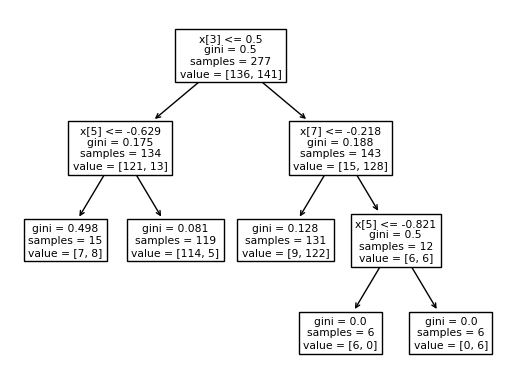

In [196]:
DTC = tree.DecisionTreeClassifier(
        criterion='gini', # gini purity measusre
        splitter='best',
        min_samples_split=5, # will not split reagions that have less than 4 sample points 
        min_samples_leaf=3,  # minimal leaf size
        random_state = 0, # if more than one split generates the same gini index, than a spit will be chosen at random. 
                        # Adding this 'seed' should secure determininistic behavior
        max_features = None,# Use all features at each split.
        ccp_alpha = 0.01 # This is a regularization feature, i.e the tree will be pruned to so that 
                # it doesn't containg too many leaves and hence doesn't oerfit
)

classifier_pruned = DTC.fit(X_train, Y_train)
tree.plot_tree(classifier_pruned)

In [197]:
classifier_pruned.score(X_test, Y_test)

0.9043478260869565

What if I just used one feautre - does the car have 4 cylinders or not? 


In [198]:
X_test_ltd = X_test[['cylinders4']]
X_train_ltd = X_train[['cylinders4']]


In [199]:
DTC = tree.DecisionTreeClassifier() # use default settings
classifier_ltd = DTC.fit(X_train_ltd, Y_train)
classifier_ltd.score(X_test_ltd, Y_test)

0.9217391304347826

### Bagging

The idea is that we randomly sample n observation, say B times, from the original data set and then grow B decision trees. Having them, whenever. prediction is required we ask our B trees to provide a prediction and take the final prediciton to be the most common prediction of the B trees.

Note than we could use bagging with a different classifier than decision trees.


In [205]:
BC = BaggingClassifier(
    estimator=DTC,   # default is a decision tree classifier 
    n_estimators=100,  # this is our B - how many bagged classifiers will we produce
    max_samples=.7,  # controls the size of the random sampel from data set. If float, then should be between 0 and 1
    max_features=.7, # Controls the number of features taken into each bagged classifier. If less then 1, features will be sampled
    bootstrap=True, # if True, samples will be drawn with replacement. 
    bootstrap_features=False, # controls if features are drawn with replacment
    oob_score=False, # controls if out of bag samples are used for the generalization error
    random_state=None, # like random seed
    verbose=0, 
)

bagg_classifier = BC.fit(X_train, Y_train)



In [201]:
show_results(bagg_classifier, X_test, Y_test)

The score on test data is 0.9478260869565217


,cylinders8,cylinders6,cylinders3,cylinders4,cylinders5,displacement,horsepower,weight,acceleration,origin1,origin2,origin3,mpg,prediction
4,1,0,0,0,0,-0.126962,-0.987120,0.809149,-1.648189,1,0,0,-1.0,-1.0
5,1,0,0,0,0,0.038576,-1.077034,2.380493,-0.559396,1,0,0,-1.0,-1.0
9,1,0,0,0,0,-0.017707,-0.987120,2.330983,-1.466724,1,0,0,-1.0,-1.0
10,1,0,0,0,0,0.038576,-1.026082,2.273222,-1.103792,1,0,0,-1.0,-1.0
12,1,0,0,0,0,0.220668,-0.852249,2.326268,-1.648189,1,0,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0,0,0,1,0,1.528416,0.421533,-1.022711,1.327847,0,0,1,1.0,1.0
385,0,0,0,1,0,1.958815,0.751218,-0.982631,-0.305344,0,1,0,1.0,1.0
388,0,0,0,1,0,1.925707,0.031906,-0.999134,3.287676,0,1,0,1.0,1.0
390,0,0,0,1,0,1.727062,0.481476,-1.329199,-0.631982,0,0,1,1.0,1.0


As one can observe bagging slightly improves the overall accuracy

### Random Forest

Finally I will see how to grow a random forest and see if that again improves classification accuracy. What is a random forest and how does it differ from bagging?

Kaggle says, that RF is a kind of baging technique whith the additional distinction that samples are not only drawn from the data set but also features are sampled and RF is tree focuse, while as bagging is more general and can be used with differet types of classifiers.  

The arguments passed the RF are similar to those passed to the tree classifier, as RF will grow a forest of decision trees.



In [204]:
RF = RandomForestClassifier(
    n_estimators=100,
    criterion='gini', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', # for some reason people believe that it is best to ranodmly pick sqrt of all features for each tree 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    random_state=None, 
    verbose=0, 
    class_weight=None, 
    ccp_alpha=0.001, 
    max_samples=None)

rf_classifier = RF.fit(X_train, Y_train)
print('Random Forest accuracy is {:.3f}'.format(rf_classifier.score(X_test, Y_test)))

Random Forest accuracy is 0.922


### Boosting

Finally I try the AdaBoost ensemble alorithm. The idea here is very similar to bagging, however with one major difference. Boosting builds models sequnetially and each following model samples from original data set with weighted probabilities, in way that puts more emphasize on previously misclassified data. This sounds as a clear advatage.

In [215]:
AB = AdaBoostClassifier(
        estimator=DTC,
        n_estimators=100, 
        learning_rate=1.0, 
        algorithm='SAMME.R', 
        random_state=None
        )
ab_classifier = AB.fit(X_train, Y_train)
print('AdaBoost accuracy is {:.3f}'.format(ab_classifier.score(X_test, Y_test)))


AdaBoost accuracy is 0.870
